In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wsi.indicators.poverty import build_poverty_df
from wsi.utils import processed_data_path, raw_data_path
from wsi.mapping.iso_name import ISO_NAME

index_baseline = pd.read_csv(processed_data_path("womens_safety_index_baseline.csv"))
filled_pov = index_baseline[['ISO_code', 'Year', 'Poverty', 'Economy']]

In [3]:
poverty_df = build_poverty_df()
poverty_df['Economy'] = poverty_df['ISO_code'].map(ISO_NAME)
poverty_df

ISO_code  Year  Poverty  Economy
0         ALB  2002      1.1  Albania
1         ALB  2005      0.6  Albania
2         ALB  2008      0.2  Albania
3         ALB  2012      0.6  Albania
4         ALB  2014      1.0  Albania
...       ...   ...      ...      ...
1606      ZMB  2004     61.1   Zambia
1607      ZMB  2006     64.7   Zambia
1608      ZMB  2010     64.4   Zambia
1609      ZMB  2015     60.8   Zambia
1610      ZMB  2022     64.3   Zambia

[1611 rows x 4 columns]

In [4]:
# data from world bank, national poverty line
path = raw_data_path("indicators", "poverty_national.csv")
df = pd.read_csv(path, skiprows=4).iloc[:, :-1]
df_filtered = df[df['Indicator Code'] == 'SI.POV.NAHC']
df_pivot = df_filtered.set_index('Country Code').drop(columns=['Indicator Name', 'Indicator Code', 'Country Name'])
df_pivot.columns = df_pivot.columns.astype(int)
df_pivot = df_pivot.reset_index()  # Make Country Code a column
df_long = df_pivot.melt(id_vars='Country Code', var_name='Year', value_name='Poverty_national').rename(columns={'Country Code':'ISO_code'})
df_long.head()

ISO_code  Year  Poverty_national
0      ABW  1960               NaN
1      AFE  1960               NaN
2      AFG  1960               NaN
3      AFW  1960               NaN
4      AGO  1960               NaN

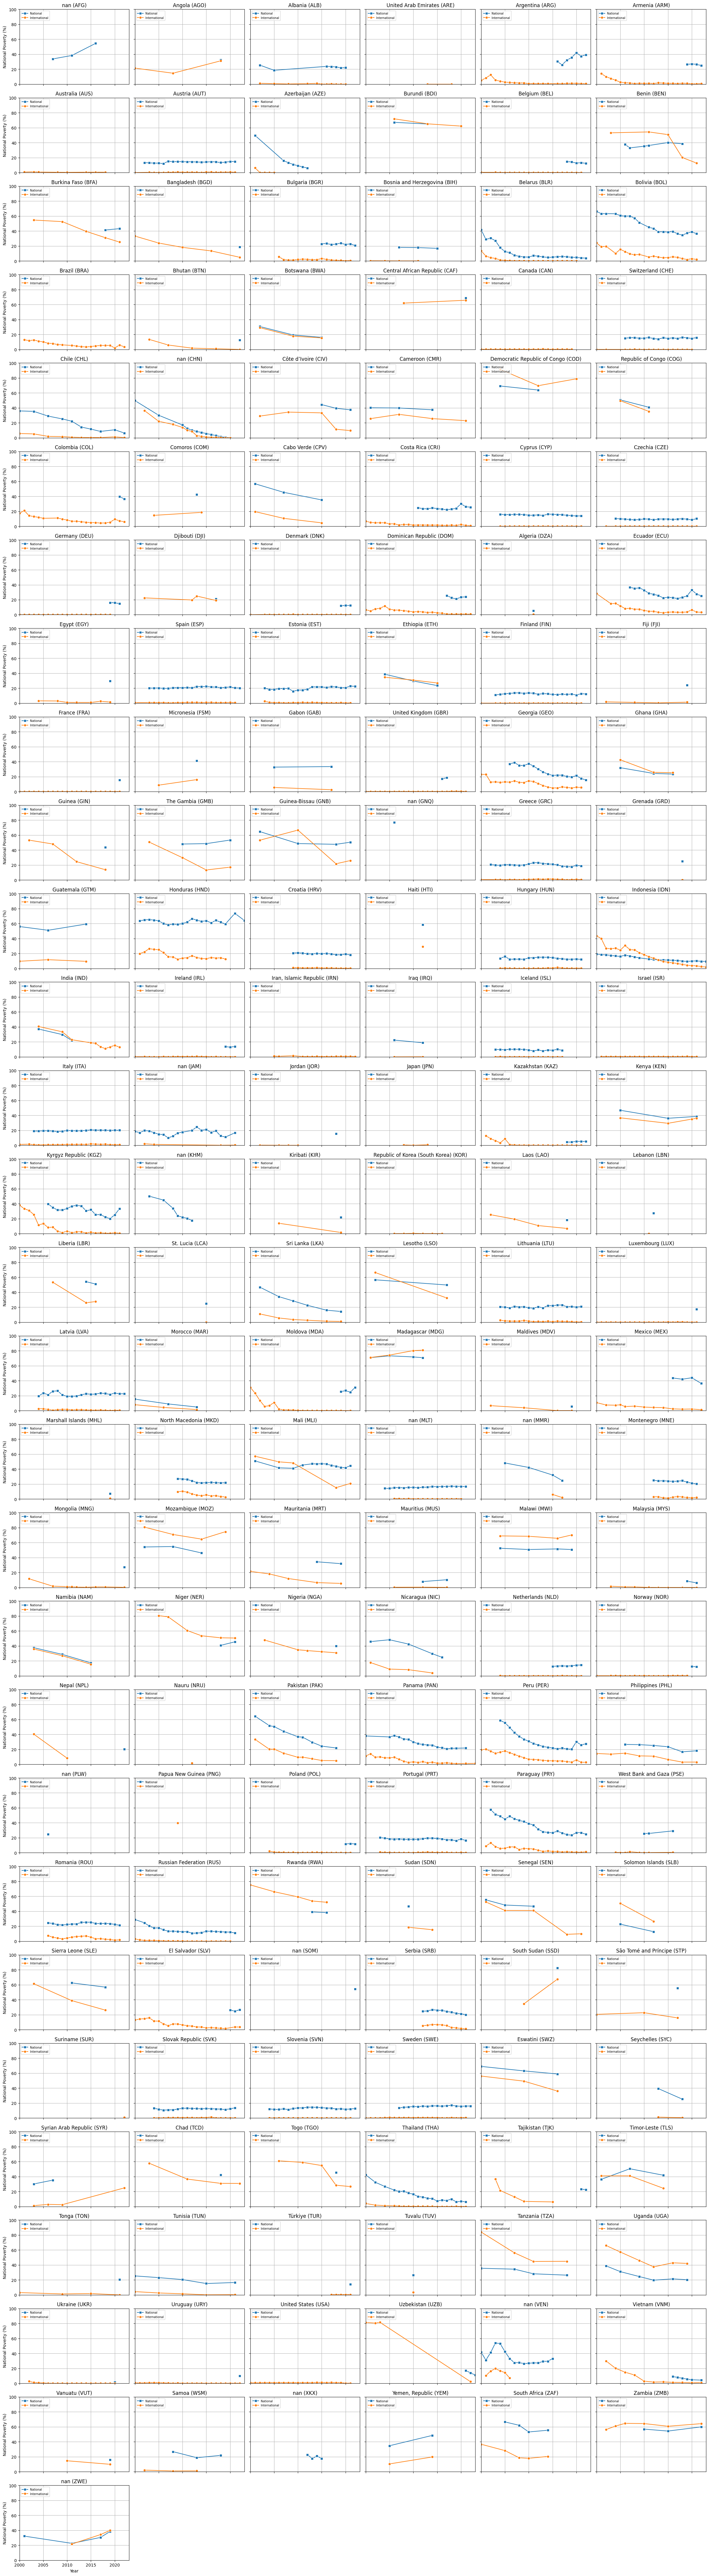

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# --- 1) Merge the two series on ISO_code & Year ---
df_merged = (
    pd.merge(df_long, poverty_df, on=['ISO_code','Year'], how='outer')
      .sort_values(['ISO_code','Year'])
)

# Rename columns for clarity
df_merged = df_merged.rename(columns={
    'Poverty_national': 'National Poverty (%)',
    'Poverty': 'International Poverty (%)'
})

# Drop rows where both series are missing
df_merged = df_merged.dropna(
    subset=['National Poverty (%)', 'International Poverty (%)'],
    how='all'
)

# --- 2) Setup plotting grid ---
countries = sorted(df_merged['ISO_code'].unique())
n_countries = len(countries)
n_cols = 6
n_rows = math.ceil(n_countries / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows),
                         sharex=True, sharey=True)
axes = axes.flatten()

# --- 3) Plot each country ---
for ax, iso in zip(axes, countries):
    sub = df_merged[df_merged['ISO_code'] == iso]
    if sub.empty:
        ax.set_visible(False)
        continue

    # Retrieve economy name
    economy = sub['Economy'].iloc[0]

    # Plot national series
    sns.lineplot(
        data=sub,
        x='Year', y='National Poverty (%)',
        marker='s', label='National', ax=ax, color='C0'
    )
    # Plot international series
    sns.lineplot(
        data=sub,
        x='Year', y='International Poverty (%)',
        marker='o', label='International', ax=ax, color='C1'
    )

    ax.set_title(f"{economy} ({iso})")
    ax.set_xlim(df_merged['Year'].min(), df_merged['Year'].max())
    ax.set_ylim(0, 100)    # percentages
    ax.grid(True)
    ax.legend(fontsize='x-small', loc='upper left')

# Hide any unused axes
for ax in axes[n_countries:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


In [6]:
df_merged

ISO_code  Year  National Poverty (%)  International Poverty (%)  \
177        AFG  2007                  33.7                        NaN   
181        AFG  2011                  38.3                        NaN   
186        AFG  2016                  54.5                        NaN   
300        AGO  2000                   NaN                       21.4   
308        AGO  2008                   NaN                       14.6   
...        ...   ...                   ...                        ...   
17222      ZMB  2022                  60.0                       64.3   
17266      ZWE  2001                  32.2                        NaN   
17276      ZWE  2011                  22.5                       21.6   
17282      ZWE  2017                  30.4                       34.2   
17284      ZWE  2019                  38.3                       39.8   

        Economy  
177         NaN  
181         NaN  
186         NaN  
300      Angola  
308      Angola  
...         ...  
17222    Zambia  
17266       NaN  
17276  Zimbabwe  
17282  Zimbabwe  
17284  Zimbabwe  

[1720 rows x 5 columns]

In [7]:
df_merged[['National Poverty (%)', 'International Poverty (%)']].corr()

National Poverty (%)  International Poverty (%)
National Poverty (%)                   1.000000                   0.653815
International Poverty (%)              0.653815                   1.000000

# Use national poverty data (where appropriate)
only when ALL data is missing from international poverty line indicator, use national poverty line information. Then apply standardmissing data logic.

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import FunctionTransformer
import warnings

warnings.filterwarnings("ignore")

# Step 1: Filter complete cases
df_valid = df_merged.dropna(subset=['National Poverty (%)', 'International Poverty (%)']).copy()
df_valid = df_valid[df_valid['National Poverty (%)'] > 0]

X_nat = df_valid[['National Poverty (%)']].values
y_intl = df_valid['International Poverty (%)'].values

results = {}

# --- Method 1: Linear Regression (intl = a * nat + b) ---
linreg = LinearRegression()
linreg.fit(X_nat, y_intl)
y_pred_linear = linreg.predict(X_nat)
mae_linear = mean_absolute_error(y_intl, y_pred_linear)
results['Linear'] = mae_linear

# --- Method 2: Log-Log Regression (log(intl) = a + b * log(nat)) ---
# Add small epsilon to avoid log(0)
epsilon = 1e-3
log_X = np.log(X_nat + epsilon)
log_y = np.log(y_intl + epsilon)

logreg = LinearRegression()
logreg.fit(log_X, log_y)
log_y_pred = logreg.predict(log_X)
y_pred_loglog = np.exp(log_y_pred) - epsilon
mae_loglog = mean_absolute_error(y_intl, y_pred_loglog)
results['Log-Log'] = mae_loglog

# --- Method 3: Fixed Ratio (intl ≈ ratio * nat) ---
# Compute global mean ratio
ratios = y_intl / X_nat.flatten()
mean_ratio = np.mean(ratios)
y_pred_ratio = mean_ratio * X_nat.flatten()
mae_ratio = mean_absolute_error(y_intl, y_pred_ratio)
results['Fixed Ratio'] = mae_ratio

# --- Print model comparison ---
print("Mean Absolute Error (lower is better):")
for model, err in results.items():
    print(f"{model}: {err:.2f}")

# Optional: Print best method
best_model = min(results, key=results.get)
print(f"\n✅ Best performing method: {best_model}")


Mean Absolute Error (lower is better):
Linear: 7.12
Log-Log: 5.48
Fixed Ratio: 6.89

✅ Best performing method: Log-Log


In [26]:
# Step 1: Make a copy to preserve original
df_predicted = df_merged.copy()

# Step 2: Group by country
country_groups = df_predicted.groupby('ISO_code')

# Step 3: Iterate and conditionally predict
for iso, group in country_groups:
    has_intl = group['International Poverty (%)'].notna().any()
    has_nat = group['National Poverty (%)'].notna().any()

    # Only predict if Intl is completely missing and National is available
    if not has_intl and has_nat:
        mask = (df_predicted['ISO_code'] == iso) & df_predicted['National Poverty (%)'].notna()

        nat_vals = df_predicted.loc[mask, 'National Poverty (%)'].values
        log_nat_vals = np.log(nat_vals + epsilon).reshape(-1, 1)
        log_pred_vals = logreg.predict(log_nat_vals)
        intl_preds = np.exp(log_pred_vals).flatten() - epsilon

        df_predicted.loc[mask, 'International Poverty (Predicted)'] = intl_preds
        df_predicted.loc[mask, 'International Poverty (Final)'] = intl_preds

# For all other rows, use actual Intl data
df_predicted['International Poverty (Final)'] = df_predicted['International Poverty (Final)'].fillna(df_predicted['International Poverty (%)'])


In [51]:
df_predicted=df_predicted[['ISO_code','Year','International Poverty (Predicted)']].dropna().copy()

# Filter for ISO_codes with more than one occurrence
iso_counts = df_predicted['ISO_code'].value_counts()
valid_isos = iso_counts[iso_counts > 1].index
to_save = df_predicted[df_predicted['ISO_code'].isin(valid_isos).values].reset_index(drop=True)

to_save.rename(columns={'International Poverty (Predicted)':'Poverty'}).to_csv(processed_data_path("intl_poverty_predictions.csv"))

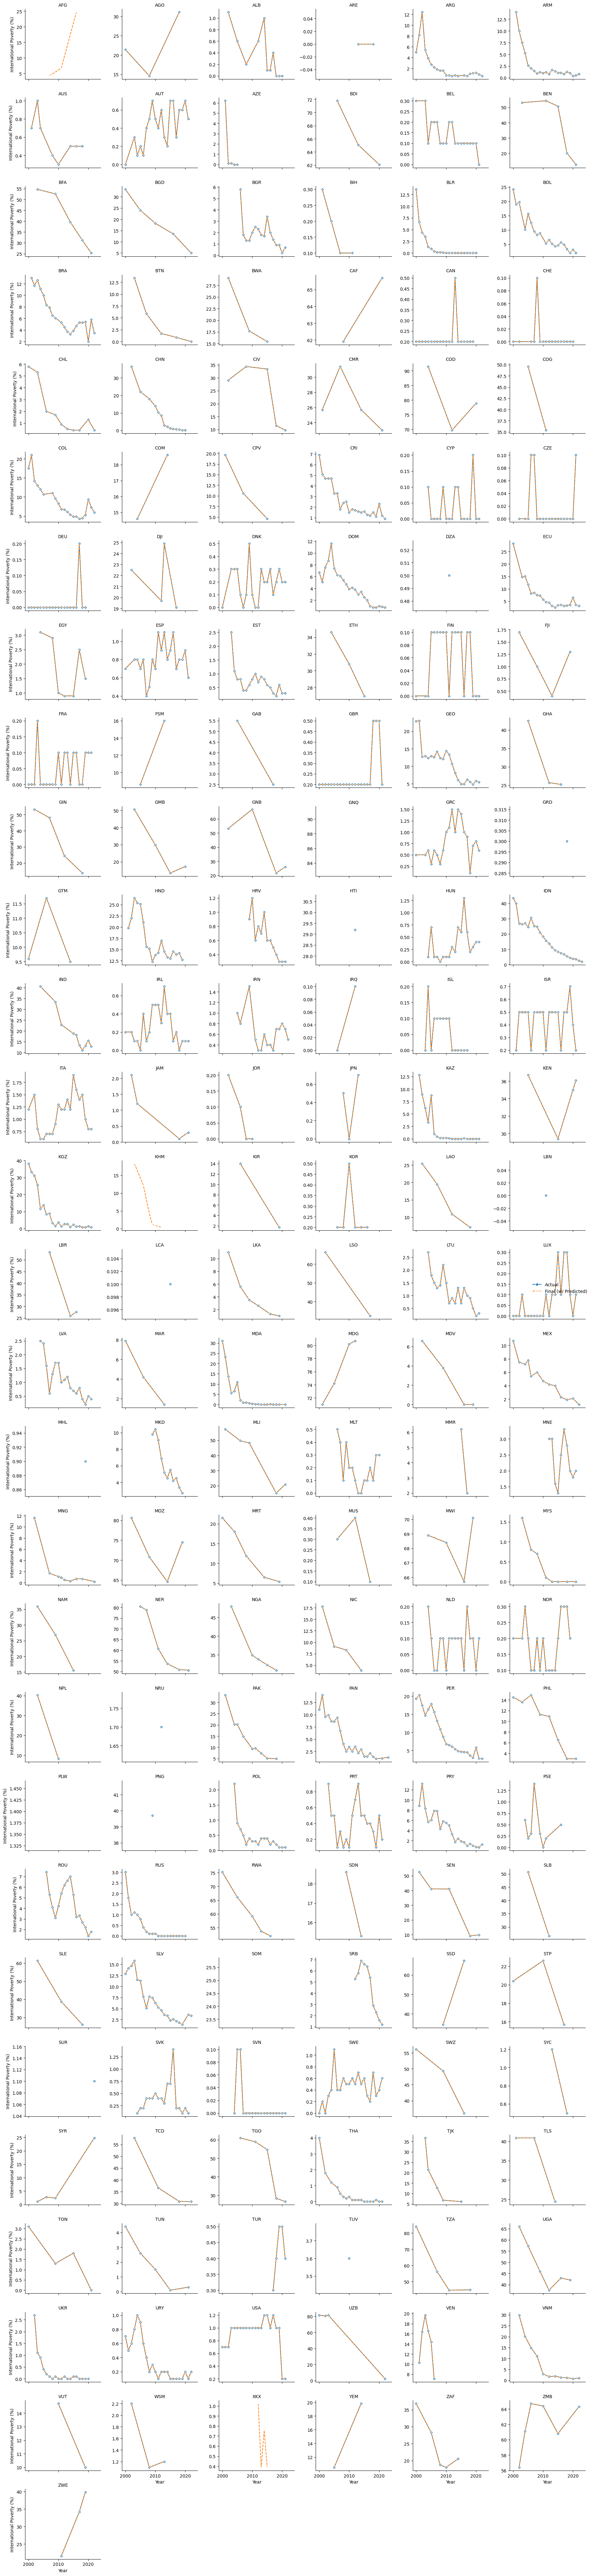

In [14]:
# Plot setup
g = sns.FacetGrid(
    df_predicted,
    col="ISO_code", col_wrap=6,
    height=2.8, sharey=False
)

# Plot actual and predicted international poverty
def plot_lines(data, **kwargs):
    ax = plt.gca()
    # Actual
    sns.lineplot(data=data, x="Year", y="International Poverty (%)", label="Actual", marker="o", ax=ax)
    # Predicted
    sns.lineplot(data=data, x="Year", y="International Poverty (Final)", label="Final (w/ Predicted)", marker="x", linestyle="--", ax=ax)

g.map_dataframe(plot_lines)
g.set_axis_labels("Year", "International Poverty (%)")
g.set_titles("{col_name}")
g.add_legend()

plt.tight_layout()
plt.show()


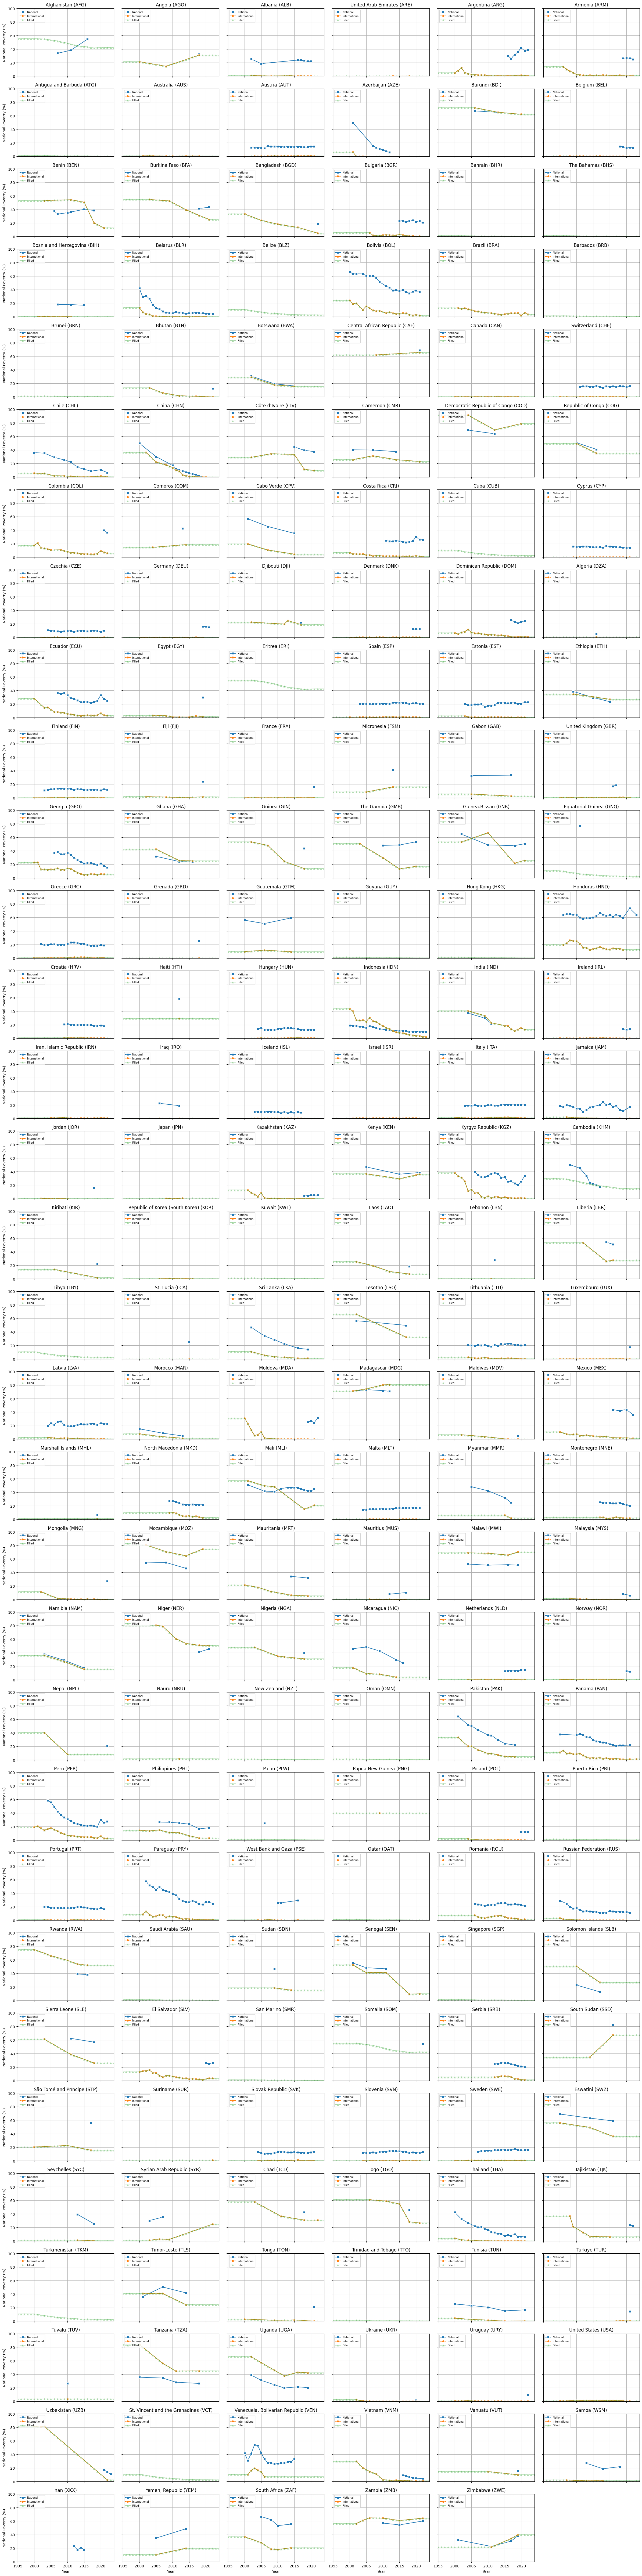

In [47]:


# --- 1) Merge the three series on ISO_code & Year ---
df_merged = (
    pd.merge(df_long, poverty_df[['ISO_code','Year','Poverty']], on=['ISO_code','Year'], how='outer')
      .rename(columns={'Poverty':'International Poverty (%)'})
      .merge(filled_pov, on=['ISO_code','Year'], how='outer')
      .rename(columns={'Poverty':'Filled Poverty (%)',
                       'Poverty_national':'National Poverty (%)'})
      .sort_values(['ISO_code','Year'])
)

# Drop rows where all three are missing
df_merged = df_merged.dropna(
    subset=['National Poverty (%)','International Poverty (%)','Filled Poverty (%)'],
    how='all'
)

# --- 2) Setup plotting grid ---
countries = sorted(df_merged['ISO_code'].unique())
n_countries = len(countries)
n_cols = 6
n_rows = math.ceil(n_countries / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows),
                         sharex=True, sharey=True)
axes = axes.flatten()

# --- 3) Plot each country ---
for ax, iso in zip(axes, countries):
    sub = df_merged[df_merged['ISO_code']==iso]
    if sub.empty:
        ax.set_visible(False)
        continue

    economy = sub['Economy'].iloc[0]

    # Plot national series
    sns.lineplot(
        data=sub,
        x='Year', y='National Poverty (%)',
        marker='s', label='National', ax=ax, color='C0'
    )
    # Plot international survey series
    sns.lineplot(
        data=sub,
        x='Year', y='International Poverty (%)',
        marker='o', label='International', ax=ax, color='C1'
    )
    # Plot filled series
    sns.lineplot(
        data=sub,
        x='Year', y='Filled Poverty (%)',
        marker='^', label='Filled', ax=ax, color='C2', alpha=0.4
    )

    ax.set_title(f"{economy} ({iso})")
    ax.set_xlim(df_merged['Year'].min(), df_merged['Year'].max())
    ax.set_ylim(0, 100)
    ax.grid(True)
    ax.legend(fontsize='x-small', loc='upper left')

# Hide any unused axes
for ax in axes[n_countries:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()
